In [1]:
import  skimage.exposure, traceback, numba, math, random
from skimage import exposure, transform, measure
from numba import jit, njit
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
plt.style.use('default')
import matplotlib.pyplot as plt
import torch as torch
from torch import nn
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GroupShuffleSplit


will not be able to render 3d later without visvis


C:\Users\Max\anaconda3\envs\CMPS_470\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


In [2]:
@jit(nopython = True)
def digitize(img, value_counts = 15, upper_range = 1000, zero_threshold = 50):
    """Function that digitizes an image from 0 to value_counts in intensity values
       
       Inspired by one of Dr. Kazim's Thresholding Lectures 

    Args:
        img :: np.ndarray or array_like
             Grayscale/single-channel input image to be processed.

        value_counts :: int     
             Int that determines n-range of values in the output image.
             Effectively rescales and then bins the image into ranges without
             resorting to a histogram.

        upper_range :: int 
             Upper threshold for pixel intensity we wish to cut our digitization off at.
             Any value in img above this will be rescaled to the last value in value_counts.
             If it is low, we effectively set a low ceiling for our image to cap out at.
             If it is high, we have a larger range for each interval obtained from value_counts.

        zero_threshold :: int    
             Lower Threshold for pixel intensity we wish to zero out before digitization.
             Any value below this value is set to 0. 
             If it is set to 0, however, it will simply count as the lower range of the first interval to bin.
             This additionally sets a floor on the range created by n (i.e. value_counts) intervals from zero_threshold to upper_range
    Returns:
        img :: np.ndarray
             Output image that has had all of its values rescaled into n (value_counts) intervals between zero_threshold and upper_range
                                
    NOTE: 
            Low zero_threshold (for instance 2,  5, 8, etc..) is susceptible to noise and must be considered if binarizing.
            Essentially, binarization or labeling down the road will be more difficult if this is set to too low of a number.
    """

    shape = img.shape
    img = img.flatten()
    if zero_threshold != 0:

        floor = zero_threshold
        
        for i in range(0,len(img)):
            if img[i] <= zero_threshold:
                 img[i] = 0 #np.array([i if i > zero_threshold else 0 for i in img]) as a list comprehension (doesn't work with numba)
            #
        #
    else:
        
        floor = 0
    #
    step = upper_range/value_counts
    bins = np.arange(floor ,upper_range, step)
    value_counts = np.arange(value_counts)

    for i, value in enumerate(img):
        keepgoing = True
        for newtarget, threshold in zip(value_counts, bins): 
            if keepgoing and value < threshold:
                img[i] = newtarget
                keepgoing = False
            elif keepgoing and value > bins.max():
                img[i] = value_counts.max() + 1
                keepgoing = False
            #
    return img.reshape(shape)    
# end digitize

def stack_textures( image_args : 'list_like', average = False,):
    try:
        if len(image_args) == 0:
            raise IndexError('\n\nCheck that image_args is being properly passed/called.\nData must be passed as a list of slices, not a slice of lists.')

        out_image = np.zeros_like(image_args[0])

        for image in image_args:
            out_image += image
        if average:
            out_image = out_image / len(image_args)

    except Exception as e:
        traceback.print_exc() #thank you geeks4geeks for blessing us with adequate advice daily.
        
    else:
        return out_image


def show_equals(img1, img2):
    arr1 = img1.flatten()
    arr2 = img2.flatten()
    out = np.array([255 if j-i == 0 else 0 for i,j in zip(arr1, arr2)]).reshape(img1.shape)
    return out
def show_only_lesser(img1,img2, return_intensity_matrix = False):
    arr1 = img1.flatten()
    arr2 = img2.flatten()
    out = np.array([(j+i)/2 if j-i < 0 else 0 for i,j in zip(arr1, arr2)]).reshape(img1.shape)
    return out
def show_only_greater(img1,img2, return_intensity_matrix = False):
    arr1 = img1.flatten()
    arr2 = img2.flatten()
    out = np.array([(j+i)/2 if j-i > 0 else 0 for i,j in zip(arr1, arr2)]).reshape(img1.shape)
    return out

# Obtaining Data

In [3]:
f = open('./VOI_DATA/data_balanced_6Slices_1orMore_xy.bin', 'rb')
train_set_all_xy = np.load(f).reshape(2520,56, 56 )  #2520 gained from pickled array
train_label_all_xy = np.load(f)
test_set_all_xy = np.load(f).reshape(1092,56, 56 )  #1092 gained from pickled array
test_label_all_xy = np.load(f)
for i in range(0,2520):
    train_set_all_xy[i] = exposure.rescale_intensity(train_set_all_xy[i], out_range =  'uint8').astype(np.uint8)
    if i < 1092:
        test_set_all_xy[i] = exposure.rescale_intensity(test_label_all_xy[i], out_range = 'uint8').astype(np.uint8)
dataset = np.concatenate((train_set_all_xy, test_set_all_xy))
dataset_label = np.concatenate((train_label_all_xy,test_label_all_xy))
df = pd.DataFrame(dataset.reshape(3612,-1))


value_index = 0
range_list = []
for i in range(0,602):
    counter = 1
    while counter != 7:
        range_list.append(i)
        counter = 1+counter
print(len(range_list))
print(range_list[-1])
df.insert(0,'Sample',range_list)
df.insert(0,'Label', dataset_label)

range_list = []
counter = 0
dataset_desliced = np.zeros_like(dataset[0:602]) #shape only matters here
desliced_labels = []
for i in range(0, 3612, 6):
    counter = 1 + counter
    range_list.append(i//6)    
    dataset_desliced[i//6] = stack_textures([digitize(dataset[i],   15, 230, 10),
                                             digitize(dataset[i+1], 15, 230, 10),
                                             digitize(dataset[i+2], 15, 230, 10), 
                                             digitize(dataset[i+3], 15, 230, 10),
                                             digitize(dataset[i+4], 15, 230, 10),
                                             digitize(dataset[i+5], 15, 230, 10)])#dataset_desliced[i//6] = digitize(stack_textures([digitize(dataset[i], 20, 245, 10),dataset[i+1],dataset[i+2], dataset[i+4],dataset[i+5]], True), value_counts = 20, upper_range = 1000, zero_threshold = 20)
#, value_counts = 50, upper_range = 1000, zero_threshold = 150)'''
    desliced_labels.append(dataset_label[i])   
    #dataset_half_desliced[i//6] = stack_textures([dataset[i],dataset[i+1],dataset[i+2], dataset[i+4],dataset[i+5]]), value_counts = 50, upper_range = 1000, zero_threshold = 150)
    #desliced_labels.append(dataset_label[i])
df_desliced = pd.DataFrame(dataset_desliced.reshape(602,-1))

print(dataset_desliced.shape)
print(range_list[-1])
df_desliced.insert(0,'Sample',range_list)
df_desliced.insert(0,'Label', desliced_labels)

train_idx, test_idx = next(GroupShuffleSplit(train_size=.6, n_splits=2).split(df, groups=df['Sample']))
temp = df.iloc[test_idx]
test_idx2, val_idx = next(GroupShuffleSplit(train_size=.4, n_splits=2).split(temp, groups=temp['Sample']))


train_desliced_idx, test_desliced_idx = next(GroupShuffleSplit(train_size = .6, n_splits = 2).split(df_desliced, groups = df_desliced['Sample']))
temp_desliced = df_desliced.iloc[test_desliced_idx]
test_desliced_idx2, val_desliced_idx = next(GroupShuffleSplit(train_size = .6, n_splits = 2).split(temp_desliced, groups = temp_desliced['Sample']))

del(temp)
del(temp_desliced)


train_set_all_xy = df.iloc[train_idx]
train_set_all_xy_desliced = df_desliced.iloc[train_desliced_idx]

test_set_all_xy = df.iloc[test_idx2]
test_set_all_xy_desliced = df_desliced.iloc[test_desliced_idx2]

val_set_all_xy = df.iloc[val_idx]
val_set_all_xy_desliced = df_desliced.iloc[val_desliced_idx]


3612
601
(602, 56, 56)
601


In [4]:
print(train_set_all_xy.shape)
print(test_set_all_xy.shape)
print(train_set_all_xy_desliced.shape)
print(test_set_all_xy_desliced.shape)
display(test_set_all_xy_desliced)

(2166, 3138)
(576, 3138)
(361, 3138)
(144, 3138)


,Label,Sample,0,1,2,3,4,5,6,7,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
1,0.0,1,49.0,50.0,53.0,56.0,58.0,56.0,53.0,47.0,...,47.0,46.0,46.0,44.0,44.0,44.0,44.0,44.0,44.0,42.0
2,1.0,2,14.0,13.0,14.0,13.0,13.0,13.0,12.0,11.0,...,12.0,12.0,13.0,15.0,16.0,16.0,16.0,16.0,16.0,16.0
3,0.0,3,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,...,9.0,6.0,5.0,3.0,2.0,2.0,0.0,0.0,1.0,3.0
4,1.0,4,68.0,68.0,68.0,65.0,64.0,63.0,62.0,59.0,...,23.0,25.0,26.0,29.0,35.0,41.0,48.0,64.0,84.0,90.0
6,1.0,6,63.0,63.0,65.0,64.0,62.0,62.0,62.0,62.0,...,14.0,14.0,12.0,11.0,11.0,13.0,16.0,19.0,19.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0.0,232,75.0,75.0,74.0,74.0,74.0,75.0,76.0,76.0,...,8.0,9.0,7.0,6.0,7.0,8.0,9.0,9.0,7.0,7.0
233,1.0,233,7.0,6.0,5.0,4.0,5.0,4.0,4.0,2.0,...,49.0,52.0,51.0,46.0,44.0,48.0,49.0,48.0,48.0,49.0
235,0.0,235,13.0,18.0,19.0,20.0,22.0,23.0,22.0,19.0,...,88.0,88.0,88.0,88.0,87.0,86.0,86.0,84.0,84.0,84.0
238,0.0,238,13.0,12.0,14.0,17.0,22.0,27.0,31.0,35.0,...,90.0,90.0,90.0,90.0,90.0,89.0,88.0,88.0,88.0,88.0


In [5]:

## PREPROCESSING ##
train_set_all_xy = pd.DataFrame(data=train_set_all_xy)
test_set_all_xy = pd.DataFrame(data=test_set_all_xy)
val_set_all_xy = pd.DataFrame(data=val_set_all_xy)

robust = RobustScaler()

scaled_train_set_all_xy = train_set_all_xy
scaled_test_set_all_xy= test_set_all_xy
scaled_val_set_all_xy = val_set_all_xy



scaled_train_set_all_xy.iloc[:,2:] = robust.fit_transform(train_set_all_xy.iloc[:,2:])
scaled_test_set_all_xy.iloc[:,2:] = robust.fit_transform(test_set_all_xy.iloc[:,2:])
scaled_val_set_all_xy.iloc[:,2:] = robust.fit_transform(val_set_all_xy.iloc[:,2:])

scaled_train_set_all_xy = pd.DataFrame(data=scaled_train_set_all_xy)
scaled_test_set_all_xy = pd.DataFrame(data=scaled_test_set_all_xy)
scaled_val_set_all_xy = pd.DataFrame(data=scaled_val_set_all_xy)



In [6]:
print(train_set_all_xy_desliced[-0:])

     Label  Sample     0     1     2     3     4     5     6     7  ...  3126  \
0      0.0       0  76.0  74.0  73.0  73.0  73.0  75.0  75.0  75.0  ...  90.0   
1      0.0       1  49.0  50.0  53.0  56.0  58.0  56.0  53.0  47.0  ...  47.0   
2      1.0       2  14.0  13.0  14.0  13.0  13.0  13.0  12.0  11.0  ...  12.0   
5      0.0       5  66.0  66.0  68.0  69.0  70.0  72.0  73.0  75.0  ...  57.0   
9      0.0       9  66.0  66.0  67.0  67.0  67.0  64.0  63.0  65.0  ...  56.0   
..     ...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
595    0.0     595   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
596    0.0     596   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
597    0.0     597   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
598    0.0     598   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
600    1.0     600   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

     3127  3128  3129  3130

# ANN

## Model

In [23]:



class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.layer_1 = nn.Linear(in_features = 56*56, out_features= 1000)
        self.layer_2 = nn.Linear(1000,500)
        self.layer_3 = nn.Linear(500,100)
        self.out_layer = nn.Linear(100,1)

        self.relu = nn.ReLU()

        # Preventing Co-Adaptation of feature detectors - https://arxiv.org/abs/1207.0580

        self.dropout = nn.Dropout()

        # Reducing Internal Covariate Shift - https://arxiv.org/abs/1502.03167



    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        logits = self.out_layer(x)
        #logits is the vector of raw (non-normalized) predictions
        return logits



def train(data,model,loss_fn,optimizer):
    size = len(data.dataset)

    for batch,(x,y) in enumerate(data):

        x,y = x.to(device),y.to(device)

        y = y.unsqueeze(1)

        pred = model(x)
        loss = loss_fn(pred,y.type_as(pred))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:


            # print(f"Data Size: {size:}")
            # print(f"x Size: {len(x):}")
            # print(f"x first 10 elements: {x[0:10]:}")
            # print(f"y Size: {len(y):}")
            # print(f"y first 10 elements: {y[0:10]:}")

            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
def val(data, model, loss_fn):
    size = len(data)
    e_loss, e_acc, loss, acc = 0,0,0,0 # zeroing values


    # We don't need to track computations when we're only doing forward computations.
    with torch.no_grad():
        for x, y in data:
            pred = model(x)

            loss += loss_fn(pred,y.unsqueeze(1).type_as(pred))
            acc += model_acc(pred,y.unsqueeze(1))

        e_loss += loss.item()
        e_acc += acc.item()
        print(f"Test Error: \n Accuracy: {(e_acc/len(data)):>0.1f}%, Avg loss: {e_loss/len(data):>8f} \n")



def model_acc(pred, y):
    pred_tag = torch.round(torch.sigmoid(pred))

    correct_results_sum = (pred_tag == y).sum().float()
    acc = correct_results_sum/y.shape[0]
    acc = torch.round(acc * 100)

    return acc



## Training

In [27]:
# Hyperparameters

learning_rate = 1e-6
batch_size = 10
epochs = 10



from torch.utils.data import DataLoader,TensorDataset

tr_features = torch.tensor(train_set_all_xy_desliced.iloc[:,2:].values, dtype=torch.float32)
tr_targets = torch.tensor(train_set_all_xy_desliced['Label'].values,dtype=torch.long)

te_features = torch.tensor(test_set_all_xy_desliced.iloc[:,2:].values, dtype= torch.float32)
te_targets = torch.tensor(test_set_all_xy_desliced['Label'].values, dtype= torch.long)

val_features = torch.tensor(val_set_all_xy_desliced.iloc[:,2:].values, dtype= torch.float32)
val_targets = torch.tensor(val_set_all_xy_desliced['Label'].values, dtype= torch.long)

tr_dataset = TensorDataset(tr_features, tr_targets)
te_dataset = TensorDataset(te_features, te_targets)
val_dataset = TensorDataset(val_features, val_targets)

train_dataloader = DataLoader(tr_dataset, batch_size = batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle= False)
test_dataloader = DataLoader(te_dataset, batch_size = batch_size, shuffle = False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = ANN()
model.to(device)
# Parameters
loss_fn = nn.BCEWithLogitsLoss()
"""

BCEWithLogitsLoss - Pytorch Documentation -

This loss combines a Sigmoid layer and the BCELoss (Binary Cross Entropy) in one single class.
This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as,
by combining the operations into one layer,
we take advantage of the log-sum-exp trick for numerical stability.

"""


#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters())

model.train() # Sets model to training mode

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    val(val_dataloader, model, loss_fn)
    torch.save(model.state_dict(),'model_weights.pth')
print("Done!")

cpu
Epoch 1
-------------------------------
loss: 0.866320 [    0/  361]
Test Error: 
 Accuracy: 58.1%, Avg loss: 2.043103 

Epoch 2
-------------------------------
loss: 1.037659 [    0/  361]
Test Error: 
 Accuracy: 57.3%, Avg loss: 0.763818 

Epoch 3
-------------------------------
loss: 0.667060 [    0/  361]
Test Error: 
 Accuracy: 52.1%, Avg loss: 0.739492 

Epoch 4
-------------------------------
loss: 0.859139 [    0/  361]
Test Error: 
 Accuracy: 60.3%, Avg loss: 0.638006 

Epoch 5
-------------------------------
loss: 0.509098 [    0/  361]
Test Error: 
 Accuracy: 53.1%, Avg loss: 0.680290 

Epoch 6
-------------------------------
loss: 0.546118 [    0/  361]
Test Error: 
 Accuracy: 64.1%, Avg loss: 0.623595 

Epoch 7
-------------------------------
loss: 0.706215 [    0/  361]
Test Error: 
 Accuracy: 52.6%, Avg loss: 1.181939 

Epoch 8
-------------------------------
loss: 1.058281 [    0/  361]
Test Error: 
 Accuracy: 57.7%, Avg loss: 0.844162 

Epoch 9
--------------------

## Predicting

In [44]:
import itertools
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ANN()
 # Setting on Eval Mode
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(device)
        y_pred = model(x)
        y_pred = torch.sigmoid(y_pred)
        y_pred_tmp = torch.round(y_pred)
        y_pred_list.append(y_pred_tmp.numpy())
        y_true_list.append((y.numpy().astype('float64')))

y_pred_list = [i.ravel().tolist() for i in y_pred_list]
y_true_list = [i.ravel().tolist() for i in y_true_list]

y_pred_list = list(itertools.chain.from_iterable(y_pred_list))
y_true_list = list(itertools.chain.from_iterable(y_true_list))


print(sk.metrics.classification_report(y_true_list, y_pred_list))


# SVM

              precision    recall  f1-score   support

         0.0       0.58      0.80      0.67        79
         1.0       0.56      0.31      0.40        65

    accuracy                           0.58       144
   macro avg       0.57      0.55      0.53       144
weighted avg       0.57      0.58      0.55       144



## Model

In [45]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import expon
from hypopt import GridSearch

In [46]:




train_X = train_set_all_xy_desliced.iloc[:,2:].values
test_X  = test_set_all_xy_desliced.iloc[:,2:].values
val_X   = val_set_all_xy_desliced.iloc[:,2:].values

train_y = train_set_all_xy_desliced['Label']
test_y  = test_set_all_xy_desliced['Label']
val_y   = val_set_all_xy_desliced['Label']


LinearSVM = SVC( kernel = 'linear', break_ties = True)
RadialSVM = SVC( kernel = 'rbf',  break_ties = True)
PolynomialSVM = SVC ( kernel = 'poly', break_ties = True)

In [47]:
LinearSVM.fit(train_X,train_y)
RadialSVM.fit(train_X,train_y)
PolynomialSVM.fit(train_X, train_y)

SVC(break_ties=True, kernel='poly')

In [48]:
Linear_results = LinearSVM.predict(test_X)
Radial_results = RadialSVM.predict(test_X)
Polynomial_results = PolynomialSVM.predict(test_X)

lright,rright,pright, lwrong,rwrong,pwrong = 0, 0,0,0,0,0
for linear, radial, polynomial, real in zip(Linear_results, Radial_results, Polynomial_results, test_y.to_list()):
    if linear == real:
        lright = lright + 1
    else:
        lwrong = lwrong + 1
    if radial == real:
        rright = rright + 1
    else:
        rwrong = rwrong + 1
    if polynomial == real:
        pright = pright + 1
    else:
        pwrong = pwrong + 1


print(f'----------------------------\nLinear SVM:\nRight : {lright}\nWrong : {lwrong}\nCorrect : {lright/144}\n----------------------------\n')
print(f'----------------------------\nRadial SVM:\nRight : {rright}\nWrong : {rwrong}\nCorrect : {rright/144}\n----------------------------\n')
print(f'----------------------------\nPolynomial SVM:\nRight : {pright}\nWrong : {pwrong}\nCorrect : {pright/144}\n----------------------------\n')
LinearSVM.get_params()

----------------------------
Linear SVM:
Right : 118
Wrong : 26
Correct : 0.8194444444444444
----------------------------

----------------------------
Radial SVM:
Right : 114
Wrong : 30
Correct : 0.7916666666666666
----------------------------

----------------------------
Polynomial SVM:
Right : 114
Wrong : 30
Correct : 0.7916666666666666
----------------------------



{'C': 1.0,
 'break_ties': True,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

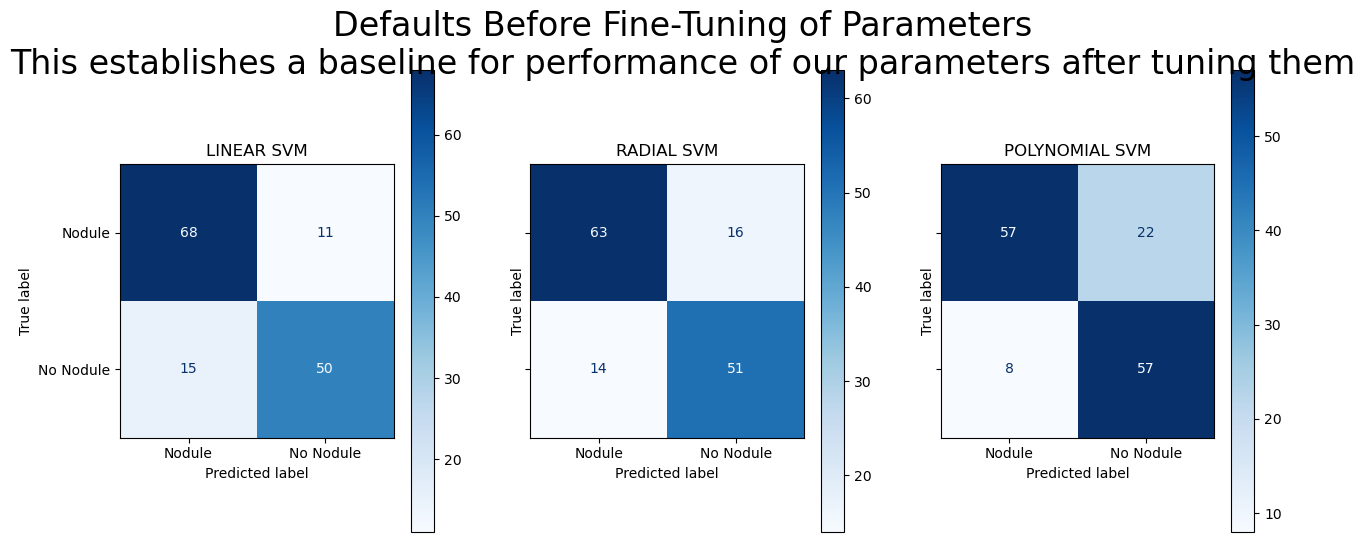

In [49]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize= (15,6),sharey = True, )
fig.suptitle('Defaults Before Fine-Tuning of Parameters\nThis establishes a baseline for performance of our parameters after tuning them', fontsize = 24)
ax1.set_title('LINEAR SVM')
ax2.set_title('RADIAL SVM')
ax3.set_title('POLYNOMIAL SVM')
plot_confusion_matrix(LinearSVM, test_X, test_y, display_labels = ['Nodule', 'No Nodule'], include_values = True, ax = ax1, cmap = plt.cm.Blues)
plot_confusion_matrix(RadialSVM, test_X, test_y, display_labels = ['Nodule', 'No Nodule'], include_values = True, ax = ax2, cmap = plt.cm.Blues)
plot_confusion_matrix(PolynomialSVM, test_X, test_y, display_labels = ['Nodule', 'No Nodule'], include_values = True, ax = ax3, cmap = plt.cm.Blues)

#,'False Positive','FALSE NEGATIVE','True Negative'})

In [50]:
C_to_test = np.geomspace(.001, 100, 5)
gamma_to_test = ['scale','auto',.05,.1,.4,.5,.9,1,3]
param_grid = [
    {'C': C_to_test, 'gamma' : gamma_to_test,'degree' : [0], 'kernel' :['rbf'] },
    {'C': C_to_test, 'gamma' : ['scale'], 'degree': [1,2,3,4], 'kernel': ['poly']}
]

optimized_SVM = GridSearch(
    model = SVC(),
    param_grid = param_grid,
    parallelize = False,

)

optimized_SVM.fit(train_X, train_y, val_X, val_y)
print(optimized_SVM.get_ranked_scores())

[0.845360824742268, 0.845360824742268, 0.8350515463917526, 0.8247422680412371, 0.8144329896907216, 0.8144329896907216, 0.8041237113402062, 0.8041237113402062, 0.7938144329896907, 0.7938144329896907, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7731958762886598, 0.7422680412371134, 0.7422680412371134, 0.6804123711340206, 0.6804123711340206, 0.6701030927835051, 0.6597938144329897, 0.6494845360824743, 0.6391752577319587, 0.6391752577319587, 0.6185567010309279, 0.6185567010309279, 0.5463917525773195, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0.5257731958762887, 0

{'C': 100.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}

            C  degree  gamma kernel  ACCURACY SCORE
0  100.000000       1  scale   poly        0.845361
1    5.623413       0  scale    rbf        0.845361
2  100.000000       0  scale    rbf        0.835052
3  100.000000       2  scale   poly        0.824742
4    5.623413       4  scale   poly        0.814433


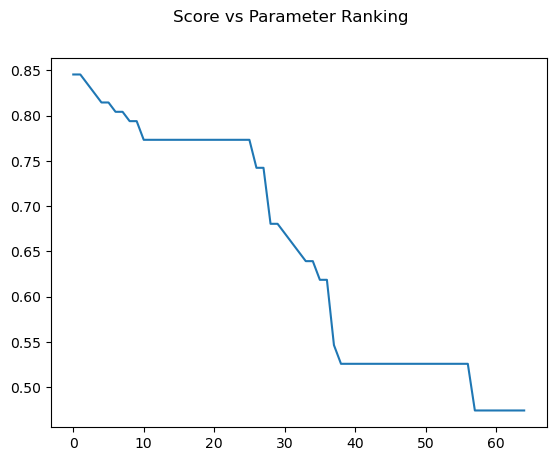

In [51]:
best = optimized_SVM.get_best_params()
display(optimized_SVM.get_best_params())

SCORES = pd.DataFrame.from_dict(optimized_SVM.get_ranked_params())
SCORES['ACCURACY SCORE'] = optimized_SVM.get_ranked_scores()
plt.figure()
plt.suptitle('Score vs Parameter Ranking')
plt.plot(SCORES['ACCURACY SCORE'])
print(SCORES.head())


              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87        79
         1.0       0.83      0.85      0.84        65

    accuracy                           0.85       144
   macro avg       0.85      0.85      0.85       144
weighted avg       0.85      0.85      0.85       144



<Figure size 640x480 with 0 Axes>

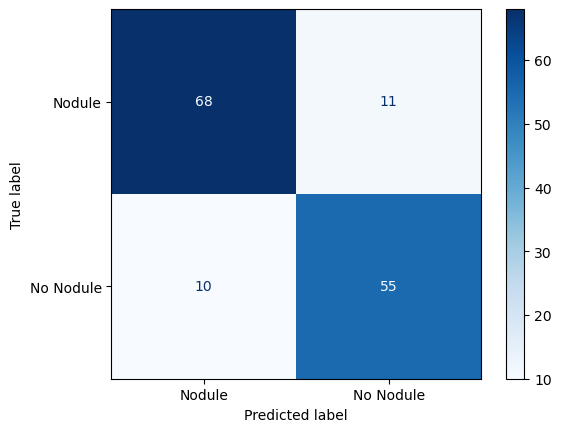

In [53]:
plt.figure()
plt.suptitle('After Fine Tuning')
Optimal_SVM = SVC(C = best['C'], gamma = best['gamma'], kernel = best['kernel'] )
Optimal_SVM.fit(train_X, train_y)
plot_confusion_matrix(Optimal_SVM, test_X, test_y, display_labels = ['Nodule', 'No Nodule'], include_values = True, cmap = plt.cm.Blues)
svm_pred = Optimal_SVM.predict(test_set_all_xy_desliced.iloc[:,2:])
print(classification_report(test_set_all_xy_desliced.iloc[:,0],svm_pred))

## Decision Tree

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import export_graphviz
from sklearn.model_selection import PredefinedSplit
from sklearn import tree
from hypopt import GridSearch
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report

In [29]:


gs = GridSearch(model = tree.DecisionTreeClassifier(),
                param_grid={'criterion': ['gini','entropy'],
                'max_depth':range(1,10),
                'min_samples_split': (range(2, 10))},
                parallelize=False)
                #Parallelize is broken on 3.7.1 and author did not fix, set to False until.


gs.fit(train_set_all_xy_desliced.iloc[:,2:], train_set_all_xy_desliced.iloc[:,0],
            val_set_all_xy_desliced.iloc[:,2:], val_set_all_xy_desliced.iloc[:,0],
            verbose=True, scoring_params='f1')








Comparing 144 parameter setting(s) using 8 CPU thread(s) ( 18 job(s) per thread ).


DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=9,
                       random_state=0)

In [36]:


grid_predict = gs.predict(test_set_all_xy_desliced.iloc[:,2:])

## Performance Assessment

In [37]:
print(classification_report(test_set_all_xy_desliced.iloc[:,0],grid_predict))

print(gs.best_estimator_)
print('Test Score for Optimized Parameters:', gs.score(test_set_all_xy_desliced.iloc[:,2:], test_set_all_xy_desliced.iloc[:,0]))


tree_model = gs.best_estimator_
print(gs.best_score, gs.best_params)

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        79
         1.0       0.85      0.82      0.83        65

    accuracy                           0.85       144
   macro avg       0.85      0.85      0.85       144
weighted avg       0.85      0.85      0.85       144

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=9,
                       random_state=0)
Test Score for Optimized Parameters: 0.8541666666666666
0.8556701030927835 {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3}


## Model Visualization

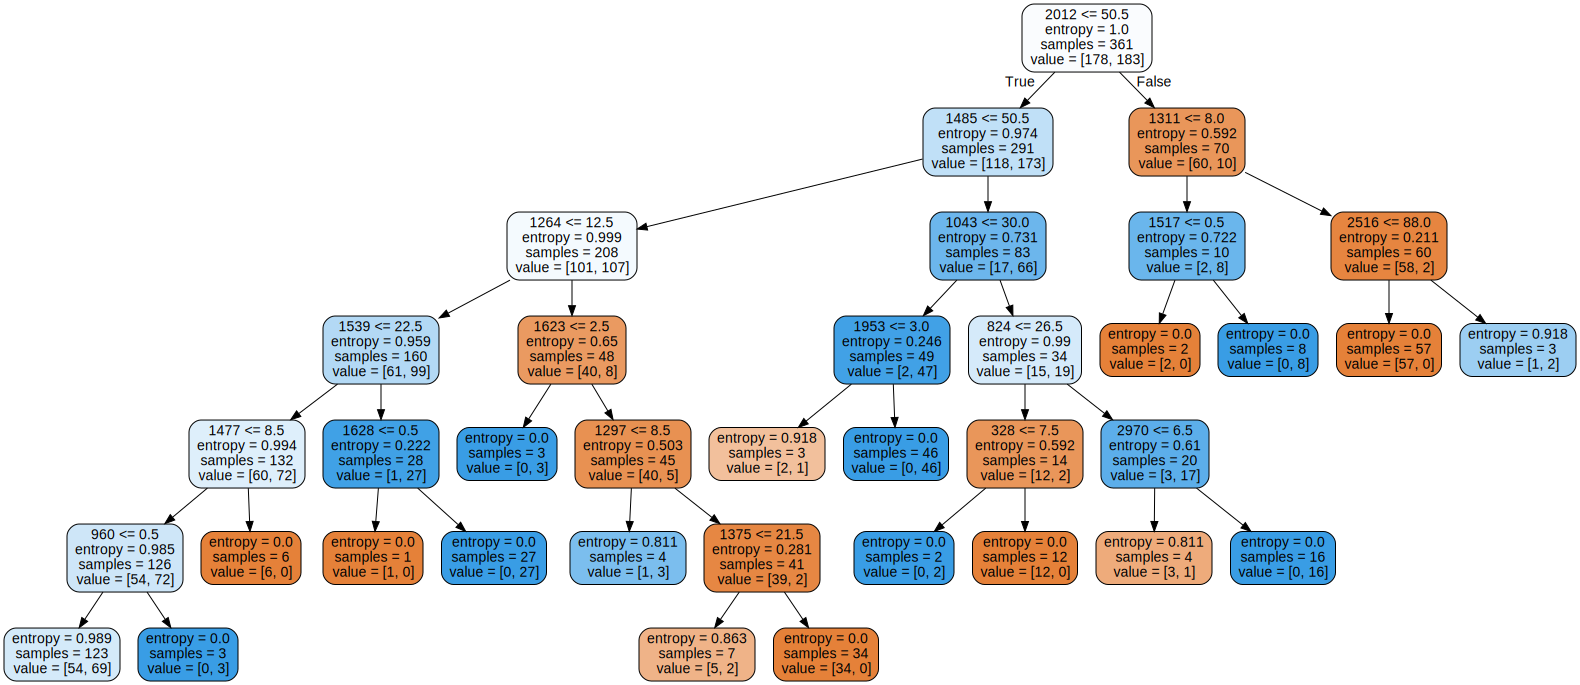

In [38]:
import graphviz

from sklearn.tree import export_graphviz
g_data = export_graphviz(gs.best_estimator_, out_file=None,
            filled=True, rounded=True, feature_names = train_set_all_xy_desliced.columns[2:])
graph = graphviz.Source(g_data)
graph.format = 'png'
graph.render('g_viz_dtree_render', view=True)
graph

## Distributions

In [39]:
import functools
from matplotlib import pyplot as plt
plt.style.use('default')





def dist_viz(df,name,index):
    for i in range(1,len(df.index)):
        ax[index].hist(df[i], label='Image #'+ str(i), histtype="step")
    ax[index].set_title(name)

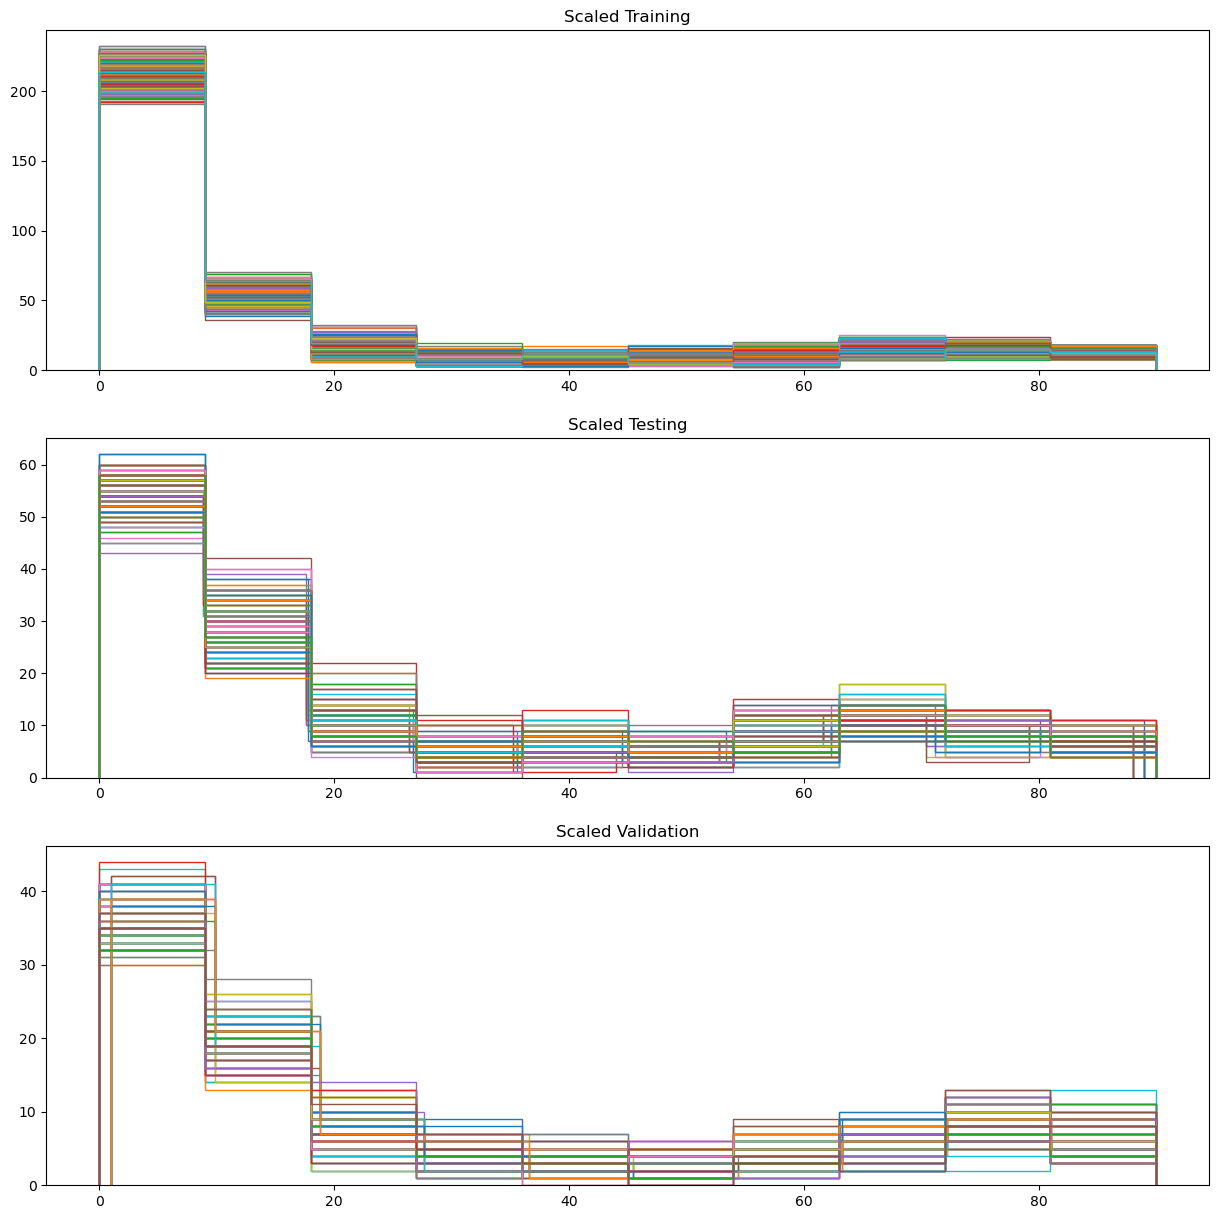

In [43]:
fig, ax = plt.subplots(3,figsize=(15,15))


dist_viz(train_set_all_xy_desliced,"Scaled Training",0)
dist_viz(test_set_all_xy_desliced,"Scaled Testing",1)
dist_viz(val_set_all_xy_desliced,"Scaled Validation",2)
plt.savefig('scaled_data_dist',bbox_inches='tight')
plt.show()




